---
title: Pangeo X EarthCODE
subtitle: D.03.10 HANDS-ON TRAINING - EarthCODE 101 Hands-On Workshop - Example showing how to access data on the EarthCODE Open Science Catalog and working with the Pangeo ecosystem on EDC
authors:
  - name: Deyan Samardzhiev
    github: sunnydean
    orcid: 0009-0003-3803-8522
    affiliations:
      - id: Lampata UK
        institution: Lampata UK
reviewers:
  - name: Anne Fouilloux
    orcid: 0000-0002-1784-2920
    github: annefou
    affiliations:
      - id: Simula Research Laboratory
        institution: Simula Research Laboratory
        ror: 00vn06n10
date: 2025-06-01
thumbnail: https://raw.githubusercontent.com/ESA-EarthCODE/documentation/refs/heads/main/pages/public/img/EarthCODE_kv_transparent.png
keywords: ["earthcode", "pangeo", "stac", "xarray", "earth observation", "remote sensing"]
tags: ["pangeo"]
releaseDate: 2025-06-01
datePublished: 2025-06-01
dateModified: 2025-06-01
banner: ../static/PANGEO.png
github: https://github.com/sunnydean/LPS25_Pangeo_x_EarthCODE_Workshop
license: MIT
---

## Table of Content
```{contents}
:depth: 1
```

## Context
We will be using the [Pangeo](https://pangeo.io/) open-source software stack to demonstrate how to fetch EarthCODE published data and publically available Sentinel-2 data to generate burn severity maps for the assessment of the areas affected by wildfires.

In this workshop, we will be using the [SeasFire Data Cube](https://opensciencedata.esa.int/products/seasfire-cube/collection) published to the EarthCODE Open Science Catalog.


### Methodology approach
* Analyse and find burnt areas using SeasFire Data Cube
* Access Sentinel-2 L2A cloud optimised dataset through STAC
* Compute the Normalised Burn Ratio (NBR) index to highlight burned areas
* Classify burn severity

### Highlights
* Using OSC data
* The NBR index uses near-infrared (NIR) and shortwave-infrared (SWIR) wavelengths.


## Data
We will use Sentinel-2 data accessed via [element84's STAC API](https://element84.com/earth-search/) endpoint and the [SeasFire Data Cube](https://opensciencedata.esa.int/products/seasfire-cube/collection) to find burned areas, inspect them in more detail and generate burn severity maps for the assessment of the areas affected by wildfires.



#### Related publications
* https://www.sciencedirect.com/science/article/pii/S1470160X22004708#f0035
* https://github.com/yobimania/dea-notebooks/blob/e0ca59f437395f7c9becca74badcf8c49da6ee90/Fire%20Analysis%20Compiled%20Scripts%20(Gadi)/dNBR_full.py
* *Alonso, Lazaro, Gans, Fabian, Karasante, Ilektra, Ahuja, Akanksha, Prapas, Ioannis, Kondylatos, Spyros, Papoutsis, Ioannis, Panagiotou, Eleannna, Michail, Dimitrios, Cremer, Felix, Weber, Ulrich, & Carvalhais, Nuno. (2022). SeasFire Cube: A Global Dataset for Seasonal Fire Modeling in the Earth System (0.4) [Data set]. Zenodo. @alonso-2024. The same dataset can also be downloaded from Zenodo: https://zenodo.org/records/13834057*
* *https://registry.opendata.aws/sentinel-2-l2a-cogs/*

### Import Packages

As best practices dictate, we recommend that you install and import all the necessary libraries at the top of your Jupyter notebook.

In [2]:
import json
import xarray
import rasterio

from datetime import datetime
from datetime import timedelta

import numpy as np
import pandas as pd
import geopandas as gpd

import hvplot.xarray
import dask.distributed

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely import geometry

from pystac_client import Client as pystac_client
from odc.stac import configure_rio, stac_load

import os
import xrlint.all as xrl
from xcube.core.verify import assert_cube


# Create and startup your Dask Cluster

Create dask cluster as described in the [dask 101 guide](../pangeo101/dask101.ipynb). 

In [ ]:
from dask_gateway import Gateway
gateway = Gateway()

In [ ]:
#WARNING In case you already created gateway cluster, you will see list of your clusters. 
#And this cell will kill all your orphan clusters.
#Please clean them before you make a new cluster using following command 
clusters = gateway.list_clusters()
print(clusters)

for cluster in clusters:
    cluster = gateway.connect(cluster.name)
    cluster.shutdown()

In [ ]:
cluster = gateway.new_cluster()
cluster.scale(2)
client = cluster.get_client()
client

In [2]:
# or create a local dask cluster on a local machine.

# from dask.distributed import Client
# client = Client()   
# client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52378,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:52391,Total threads: 2
Dashboard: http://127.0.0.1:52392/status,Memory: 4.80 GiB
Nanny: tcp://127.0.0.1:52381,


# Load the Data

Lazy load in data in Xarray as described in the [xarray 101 guide](../pangeo101/xarray101.ipynb). Note that the SeasFire data is +100GB and hosted remotely, we are just loading metadata, xarray will load only the chunks (dask data arrays) needed for our computations as discussed in the [dask 101 guide](../pangeo101/dask101.ipynb).

The SeasFire Cube contains various variables for forecasting seasonal fires across the globe, we will specifically be using it to access historical wildfire data:

*The SeasFire Cube is a scientific datacube for seasonal fire forecasting around the globe. It has been created for the SeasFire project, that adresses 'Earth System Deep Learning for Seasonal Fire Forecasting' and is funded by the European Space Agency (ESA)  in the context of ESA Future EO-1 Science for Society Call. It contains almost 20 years of data (2001-2021) in an 8-days time resolution and 0.25 degrees grid resolution. It has a diverse range of seasonal fire drivers. It expands from atmospheric and climatological ones to vegetation variables, socioeconomic and the target variables related to wildfires such as burned areas, fire radiative power, and wildfire-related CO2 emissions.*

In [3]:
http_url = "https://s3.waw4-1.cloudferro.com/EarthCODE/OSCAssets/seasfire/seasfire_v0.4.zarr/"

ds = xarray.open_dataset(
	http_url,
	engine='zarr',
    chunks={},
	consolidated=True
	# storage_options = {'token': 'anon'}
)
ds

<xarray.Dataset> Size: 164GB
Dimensions:                         (latitude: 720, longitude: 1440, time: 966)
Coordinates:
  * latitude                        (latitude) float64 6kB 89.88 ... -89.88
  * longitude                       (longitude) float64 12kB -179.9 ... 179.9
  * time                            (time) datetime64[ns] 8kB 2001-01-01 ... ...
Data variables: (12/59)
    area                            (latitude, longitude) float32 4MB dask.array<chunksize=(180, 360), meta=np.ndarray>
    biomes                          (latitude, longitude) float32 4MB dask.array<chunksize=(180, 360), meta=np.ndarray>
    cams_co2fire                    (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    cams_frpfire                    (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    drought_code_max                (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    drought_code_mean               (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ...                              ...
    t2m_max                         (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    t2m_mean                        (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    t2m_min                         (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    tp                              (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    vpd                             (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ws10                            (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
Attributes:
    crs:          EPSG:4326
    description:  The SeasFire Cube is a scientific datacube for seasonal fir...
    title:        SeasFire Cube: A Global Dataset for Seasonal Fire Modeling ...

# Analyse Wildfires
Our first task will be to find the date of the largest burnt area over the region we were previously exploring, so that we may analyse it in detail.

One of the data variables from the SeasFire DataCube is the Burned Areas data from Global Wildfire Information System (GWIS). Each entry gives us the hectares (ha) of burnt area in that region. Note that our input resolution is 0.25 degrees (approx. 28x28 km per pixel), spanning 20 years (2001-2021) at an 8 days time resolution.

First we lazy load just the GWIS dataset in a variable for convenience (note that again, this does not take up a large amount of memory since we're just working with the metadata at this point)

In [1]:
gwis = ds.gwis_ba
gwis

NameError: name 'ds' is not defined

# Spatial and Temporal Subsetting
It's best practice to subset only the relevant data before doing computations, to reduce needed computations and data downloads. Especialyl when working with larger datasets. We will select an area of interest (aoi) as below using the polygon we previously downloaded from the xcube viewer.

In [43]:
# Spatial Slices

with open("../aoi/feature.json") as f:
    feature = json.load(f)["geometry"]

# make sure our projections match
bbox = list(geometry.shape(feature).bounds)
polygon = gpd.GeoDataFrame(index=[0], crs="epsg:4326", geometry=[geometry.box(*bbox)])
min_lon, min_lat, max_lon, max_lat = polygon.total_bounds

# find the nearest points on our grid
lat_start = gwis.latitude.sel(latitude=max_lat, method="nearest").item()
lat_stop  = gwis.latitude.sel(latitude=min_lat, method="nearest").item()
lon_start = gwis.longitude.sel(longitude=min_lon, method="nearest").item()
lon_stop  = gwis.longitude.sel(longitude=max_lon, method="nearest").item()

lat_slice = slice(lat_start, lat_stop)
lon_slice = slice(lon_start, lon_stop)

NameError: name 'gwis' is not defined

We additionally will subest our data temporally to fetch only more recent periods from 2018 - 2021.

In [45]:
time_slice = slice('2018-01-01','2021-01-01')

We now simply subset the data using the slices we created. Note how the data of our computation has reduced significantly

In [46]:
# spatio temporal subset
gwis_aoi = gwis.sel(time=time_slice, latitude=lat_slice,longitude=lon_slice)
gwis_aoi

NameError: name 'gwis' is not defined

# Finding the date with the most burnt area

To find the date with the most burnt area we first do a spatial sum over our data for each period; this will return an dataarray with the total amount of ha of burnt area for each day. We will then fetch the date with the max burned area using idmax.

*Note idmax is equivalent to doing ds.sel(time=ds.argmax.item(dim='time')) where argmax returns the index of the max item*

In [8]:
# date where the sum of burnt area is the highest
date_max_fire = gwis_aoi.sum(dim={'latitude','longitude'}).idxmax(dim='time')

<xarray.DataArray 'time' ()> Size: 8B
array('2020-08-04T00:00:00.000000000', dtype='datetime64[ns]')

By subsetting only to the relevant data, we have reduced our dataset from 3.7 GB to a very small managable chunk of relevant data. Note that up to this point, we have not downloaded any data or done any computations over it. We (via the Dask Client) have just built up in the background the dask task graph.

In [ ]:
date_max_fire.data.visualize(optimize_graph=True)

## Let's start computing!

Let's get our date by forcing dask to execute the above task graph using .compute()

In [ ]:
date_max_fire = date_max_fire.compute()
date_max_fire

# Exploring the Data
Great, we've found the date with the most burnt areas, now let's explore the data

In [9]:
biggest_fire_aoi = gwis_aoi.sel(time=date_max_fire)
biggest_fire_aoi

<xarray.DataArray 'gwis_ba' (latitude: 3, longitude: 4)> Size: 48B
dask.array<getitem, shape=(3, 4), dtype=float32, chunksize=(3, 4), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 24B 41.38 41.12 40.88
  * longitude  (longitude) float64 32B -7.625 -7.375 -7.125 -6.875
    time       datetime64[ns] 8B 2020-08-04
Attributes:
    aggregation:      Spatio-Temporal | sum
    creator_notes:    The missing data for the year 2001 has been filled with...
    downloaded_from:  https://gwis.jrc.ec.europa.eu/apps/country.profile/down...
    long_name:        Burned Areas from GWIS
    provider:         Global Wildfire Information System (GWIS)
    units:            hectares (ha)

Plot the forest fire areas to get an idea about our data

Let's plot our data to explore it a bit further

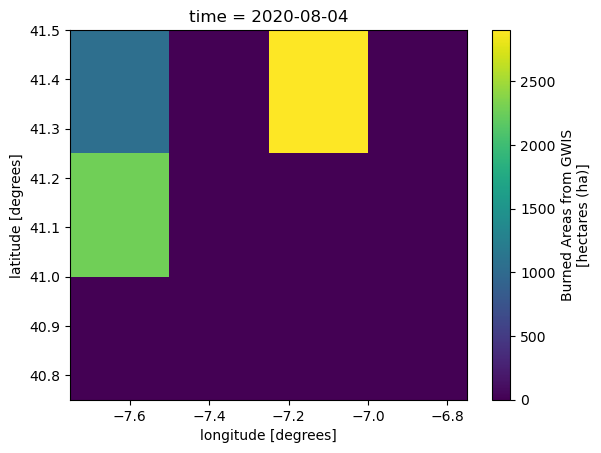

In [10]:
biggest_fire_aoi.plot()

The image above does not really give us a detailed view of which areas have been burned and to what degree, as the resolution of each pixel is approx 28km. To get some more context of our data we can plot it on a base map.

In the Pangeo stack there are visualization tools that can help us easily plot data in a more interactive way, with a simple interface - such as hvplot.

In [11]:
# Plot it interactively, with some context
biggest_fire_aoi.hvplot(
    x='longitude',
    y='latitude',
    cmap='viridis',
    colorbar=True,
    frame_width=600,
    frame_height=400,
    geo=True,
    tiles='OSM'
)


:Overlay
   .WMTS.I  :WMTS   [Longitude,Latitude]
   .Image.I :Image   [longitude,latitude]   (Burned Areas from GWIS)

# Analysing in Detail
Now that we have an idea of a potential wildfire event, we can explore in a bit more detail to see what areas where affected most. 

We will use higher resolution sentinel-2-l2a data to compute the Normalised Burn Ratio (NBR) index to highlight burned areas. The NBR index uses near-infrared (NIR) and shortwave-infrared (SWIR) wavelengths. We will use a STAC API [element84's STAC API](https://element84.com/earth-search/) endpoint to search for the data and load only the relevant, cloud-free data.

To estimate the amount of burnt area we will compute the difference between the NBR from period before the fire date and the NBR from the period after. The first step is to select the week before and the week after the wildfire

In [ ]:
fire_date_t = pd.to_datetime(date_max_fire.values.item()) # get the date of the forest fire and a the dates before and after it
week_before = (fire_date_t - timedelta(days=7))
week_after = (fire_date_t + timedelta(days=7))

In [13]:
print(week_before.date(), "---" , week_after.date())

2020-07-28 --- 2020-08-11


## Fetching the data
We will now fetch the data using pystac to search through the earth-search.aws.element84.com/v1 STAC API endpoint. As mentioned in the [STAC and Data Access guide](../earthcode101/stac_and_data_access.ipynb), the STAC API provides us with endpoints to query STAC collections.

There is an ecosystem of libraries that implement STAC standards (pystac, odc-stac, stackstac, etc..) that allow us to analyse, load and use data described in STAC. We will briefly explore in the following cells below.

As a first step, we will open a catalog with the pystac library: https://earth-search.aws.element84.com/v1 This catalog contains STAC collections of various datasets (such as sentinel-1 and sentinel-2 data) in cloud optimised formats (COGs in this case) - see https://earth-search.aws.element84.com. for more details. With these formats we are able to use the assets using cloud-native access patterns (see https://guide.cloudnativegeo.org/cookbooks/ for more details).

Note that a STAC endpoint like the one below, only returns STAC items and not the actual data. The STAC items returned have Assets defined which link to the actual data (and provide metadata).

In [30]:
catalog = pystac_client.open("https://earth-search.aws.element84.com/v1")
chunk={} # <-- use dask
res=10 # 10m resolution

In the next step we will do two things:

**1.** Search for multiple cloudless sentinel-2 satellite images within a month of our pre-fire (week_before) date. The STAC API allows us to do a couple of things in a simple API call:
- We can define an arrea of interest (bbox) and search for items that cover this region
- We can subset for the time of interest as well (datetime)
- We can define custom querries over implemented STAC extensions. For example, the Sentinel STAC collection we are querrying implements the eo STAC extension, and defines cloud_cover - this allows us to search for quality assets with minimal cloudy pixels

This will return the relevant STAC items - which contain assets that point to our data of interest. We now need to load this data into a dataarray to start analysing it.

**2.** Note that in the above step, we only have items that point to some data - this data can be tiff, zarr, netcdf, COG, or other SpatioTemporal asset data. In our case, the element84 endpoint points to the data collection of  *https://registry.opendata.aws/sentinel-2-l2a-cogs/* - the format of our data is cloud-optimized GeoTiff. A cloud-friendly format such as this enables us cloud-native access patterns, such as easily fetching only our area of interest (as opposed to several tiff files and manually building a mosaic of them).

Libraries such as odc-stac integrate with STAC standards and allow us to load data as well as leveraging the cloud-optimised formats. For example, in the cell below we define how we want to transform/load our data by:
- Passing the STAC item (or multiple items) we want to load
- defining a particular chunk size (the passed {} asks for the data to be automatically chunked as it is originally);
- We can request only the spectral bands of interest, in this case nir and swir22, to reduce the amount of data that we fetch.
- We can define a resolution to retrieve the data at, note that this will also resample automatically. For example the nir band data has a 10m resolution, but the swir22 - 20m resolution.
- There are multiple other options as well, such as defining in which projection we want our data in. More information can be found at: https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html


In [31]:
# STAC search for relevant items
week_before_start = (week_before - timedelta(days=30))
time_range = str(week_before_start.date()) + "/" + str(week_before.date())

query1 = catalog.search(
    collections=["sentinel-2-l2a"], datetime=time_range, limit=100,
    bbox=bbox, query={"eo:cloud_cover": {"lt": 0.5}}
)

items = list(query1.items())
print(f"Found: {len(items):d} datasets")

items_pre = min(items, key=lambda item: item.properties["eo:cloud_cover"])

prefire_ds = stac_load(
    [items_pre],
    bands=("nir", "swir22"),
    chunks=chunk,  # <-- use Dask
    resolution=res,
    groupby="datetime",
    bbox=bbox,
)
prefire_ds

Found: 9 datasets


<xarray.Dataset> Size: 132MB
Dimensions:      (y: 4599, x: 7151, time: 1)
Coordinates:
  * y            (y) float64 37kB 4.584e+06 4.584e+06 ... 4.538e+06 4.538e+06
  * x            (x) float64 57kB 6.119e+05 6.119e+05 ... 6.834e+05 6.834e+05
    spatial_ref  int32 4B 32629
  * time         (time) datetime64[ns] 8B 2020-07-28T11:30:02.597000
Data variables:
    nir          (time, y, x) uint16 66MB dask.array<chunksize=(1, 4599, 7151), meta=np.ndarray>
    swir22       (time, y, x) uint16 66MB dask.array<chunksize=(1, 4599, 7151), meta=np.ndarray>

We now do the same for the month after..

In [32]:
week_after_end = (week_after + timedelta(days=30))
time_range = str(week_after.date()) + "/" + str(week_after_end.date())

query2 = catalog.search(
    collections=["sentinel-2-l2a"], datetime=time_range, limit=100,
    bbox=bbox, query={"eo:cloud_cover": {"lt": 0.5}}
)

items = list(query2.items())
print(f"Found: {len(items):d} datasets")

items_post = min(items, key=lambda item: item.properties["eo:cloud_cover"])

postfire_ds = stac_load(
    [items_post],
    bands=("nir", "swir22"),
    chunks=chunk,  # <-- use Dask
    resolution=res,
    groupby="datetime",
    bbox=bbox,
)
postfire_ds

Found: 2 datasets


<xarray.Dataset> Size: 132MB
Dimensions:      (y: 4599, x: 7151, time: 1)
Coordinates:
  * y            (y) float64 37kB 4.584e+06 4.584e+06 ... 4.538e+06 4.538e+06
  * x            (x) float64 57kB 6.119e+05 6.119e+05 ... 6.834e+05 6.834e+05
    spatial_ref  int32 4B 32629
  * time         (time) datetime64[ns] 8B 2020-08-27T11:30:02.147000
Data variables:
    nir          (time, y, x) uint16 66MB dask.array<chunksize=(1, 4599, 7151), meta=np.ndarray>
    swir22       (time, y, x) uint16 66MB dask.array<chunksize=(1, 4599, 7151), meta=np.ndarray>

# Calculating the NBR index

In the next step we will calculate our index, using simple band math as explained in the [xarray 101 guide](../pangeo101/xarray101.ipynb). We first define a function that calculates our index given a dataset with nir/swir22 band data and then add the additional variable to our pre-fire/post-fire datasets

In [ ]:
index_name = 'NBR'

# Normalised Burn Ratio, Lopez Garcia 1991
def calc_nbr(ds):
    return (ds.nir - ds.swir22) / (ds.nir + ds.swir22)

index_dict = {'NBR': calc_nbr}
index_dict

In [33]:
# prefire - calls the calc_nbr function with our dataset as input to create a new NBR index (dict) and assigns it as the NBR index 
# note that we have to apply scaling (1000) and offset (0) to our band data - as defined in the dataset collection
prefire_ds[index_name] = index_dict[index_name](prefire_ds / 10000.0) 

# postfire - calls the calc_nbr function with our dataset as input to create a new NBR index (dict) and assigns it as the NBR index 
# note that we have to apply scaling (1000) and offset (0) to our band data - as defined in the dataset collection
postfire_ds[index_name] = index_dict[index_name](postfire_ds / 10000.0)

Now that we have the indecies calculated we can calculate the difference in burnt area between the two periods to analyse which regions have been burnt.

We first need to drop the time dimension (as they will be misaligned) and then simply calculate a difference. Note that at this point we haven't actually loaded the data or done the calculations, we've just defined a task graph for dask to execute. When we call persist() the graph up to that point will be executed and the data saved for in the distributed memory of our workers. We do this at this stage to avoid fetching the data multiple times in future computations.

We then save our result (which is a dataarray) in a new dataset: dnbr_dataset.

In [41]:
# calculate delta NBR
prefire_burnratio = prefire_ds.NBR.isel(time=0).persist() # <--- load and keep data into your workers
postfire_burnratio = postfire_ds.NBR.isel(time=0).persist() # <--- load and keep data into your workers

delta_NBR = prefire_burnratio - postfire_burnratio

dnbr_dataset = delta_NBR.to_dataset(name='delta_NBR') 

In [42]:
dnbr_dataset
delta_NBR

<xarray.DataArray 'NBR' (y: 4599, x: 7151)> Size: 263MB
dask.array<sub, shape=(4599, 7151), dtype=float64, chunksize=(4599, 7151), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 37kB 4.584e+06 4.584e+06 ... 4.538e+06 4.538e+06
  * x            (x) float64 57kB 6.119e+05 6.119e+05 ... 6.834e+05 6.834e+05
    spatial_ref  int32 4B 32629

# Plotting and visualization

We will now plot our data from before, after and the delta of our wildfire event to further analyse. Note that, this will trigger the execution of our dask task graph.

## Plotting Before

Text(0.5, 1.0, '28 July 2020')

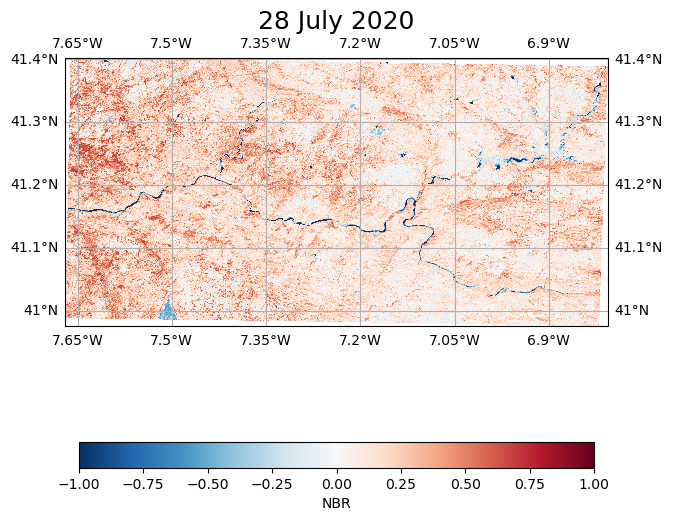

In [43]:
fig = plt.figure(1, figsize=[7, 10])

# We're using cartopy and are plotting in PlateCarree projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here Mercator)
prefire_burnratio.plot(ax=ax, transform=ccrs.epsg(prefire_burnratio.spatial_ref.values), cmap='RdBu_r',
                       cbar_kwargs={'orientation':'horizontal','shrink':0.95})

# One way to customize your title
plt.title( pd.to_datetime(prefire_burnratio.time.values.item()).strftime("%d %B %Y"), fontsize=18)

## Plotting After

Text(0.5, 1.0, '27 August 2020')

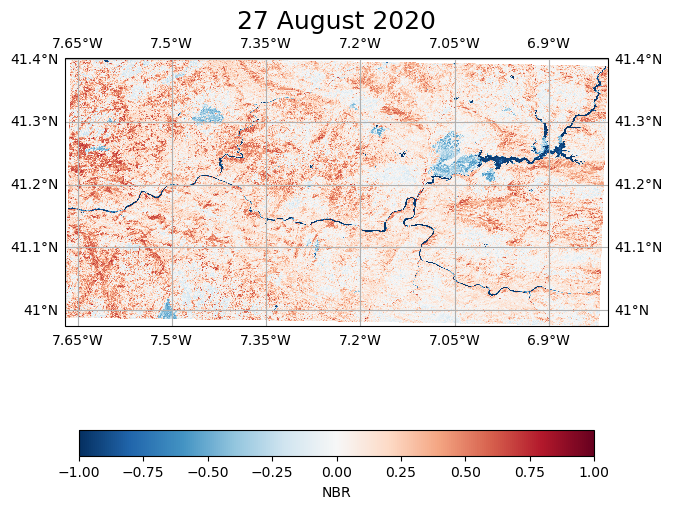

In [44]:
fig = plt.figure(1, figsize=[7, 9])

# We're using cartopy and are plotting in PlateCarree projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here Mercator)
postfire_burnratio.plot(ax=ax, transform=ccrs.epsg(postfire_burnratio.spatial_ref.values), cmap='RdBu_r',
                        cbar_kwargs={'orientation':'horizontal','shrink':0.95})

# One way to customize your title
plt.title( pd.to_datetime(postfire_burnratio.time.values.item()).strftime("%d %B %Y"), fontsize=18)

## Plotting Delta

The plot below highligths the burnt regions

Text(0.5, 1.0, 'Delta NBR')

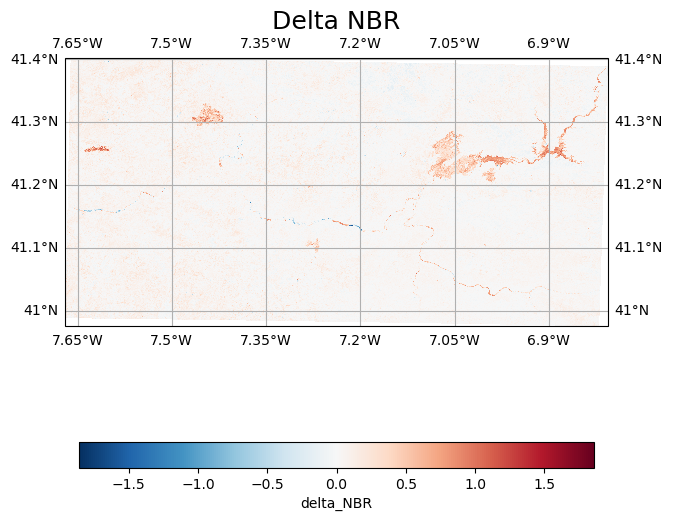

In [45]:
fig = plt.figure(1, figsize=[7, 10])

# We're using cartopy and are plotting in PlateCarree projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here Mercator)
dnbr_dataset.delta_NBR.plot(ax=ax, transform=ccrs.epsg(dnbr_dataset.delta_NBR.spatial_ref.values), cmap='RdBu_r',
                            cbar_kwargs={'orientation':'horizontal','shrink':0.95})

# One way to customize your title
plt.title( "Delta NBR", fontsize=18)

# Analysing Burnt Areas 

Great, now that we've calculated the delta NBR (dNBR), we can estimate the amount of area that was burned. First we need to classify which pixels are actually burned and then calculate the area that was burned.

To classify burned area we can use the dNBR reference ratio ratios described in: [https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio) - and estimate the moderate to severe burnt areas. **i.e. the areas with a dNBR of above 0.27**

![img](https://un-spider.org/sites/default/files/table+legend.PNG)

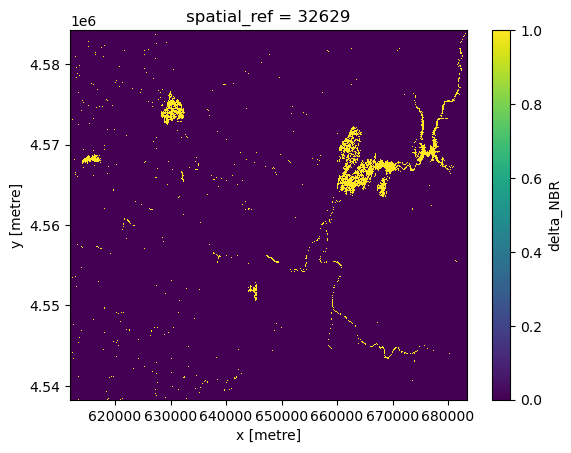

In [39]:
BURN_THRESH = 0.27
burn_mask = dnbr_dataset.delta_NBR > BURN_THRESH           # True/False mask, same shape as raster
burn_mask.plot()

# save the burn_mask to our dataset
dnbr_dataset['burned_ha_mask'] = burn_mask

# Simple Validation

Now with the above a data mask where all pixels classified as burnt are 1 and the non burnt ones are 0. To calculate burnt area, we simply sum all pixels and multiply them by the area which a pixel covers (i.e. the resolution, which in our case is 10m/p).

At the same step we will convert our metric to hectares (ha) so that we can compare and validate our findings against the original GWIS data.

*Note that in an actual study, the ground truth data and validation would involve field studies and more precise validation, but we simplify the example for the training.*

In [40]:
dx, dy = dnbr_dataset.delta_NBR.rio.resolution()
pixel_area_ha = abs(dx * dy) / 1e4       # 10m × 10m = 0.01 ha

pixels_burned   = burn_mask.sum().compute().item()   # integer number of burned pixels
burned_area_ha  = pixels_burned * pixel_area_ha

print(f"Burned area   : {burned_area_ha:,.2f} ha")
print(f"Actual Burned Area : {biggest_fire_aoi.sum().compute():,.2f}, ha")

Burned area   : 6,609.65 ha
Actual Burned Area : 6,227.64, ha


There's only a difference of about 350 ha, which, given our simple analysis, is actually quite accurate!

*note this is based on the geojson feature in the github repo* with the following result:
- Burned area   : 6,609.65 ha
- Actual Burned Area : 6,227.64, ha


## Plotting and Analysing Final Results

We can visually inspect our plot to see if our data follows the same trends as our ground truth GWIS dataset.

To achieve this though, we need to reproject our data, since the sentinel-2 data we are using is in a different projection with a higher resolution (10m/pixel) and the SeasFire GWIS ground truth data has a resolution of 0.25 degrees (approx 28km x 28 km).

We will do this using the *rioxarray library*, which offers convenient methods such as reproject_match, which takes in as an argument a dataarray to which to match the original dataset. It essentially reprojects and matches the grid of a datarray to match the grid/projection of another and upsamples (or downsamples) the data to match resolutions 

Learn more about how it works at: https://corteva.github.io/rioxarray/stable/examples/reproject_match.html

In [ ]:
# make sure our data is loaded in memory
# del?

dnbr_dataset = dnbr_dataset.persist()
biggest_fire_aoi = biggest_fire_aoi.persist()

In [ ]:
# ensure that our dataarray has metadata about its projection - this is used by rioxarray.
biggest_fire_aoi = biggest_fire_aoi.rio.write_crs(ds.rio.crs)

biggest_fire_aoi_reprojected = biggest_fire_aoi.rio.reproject(dnbr_dataset.burned_ha_mask.rio.crs)

burned_ha_mask_plot = dnbr_dataset.burned_ha_mask.hvplot(
    width=700,
    height=700,
    title='dNBR (10 m) with GWIS overlay',
    alpha=1.0
)

# Plot the reprojected coarse dataset as transparent overlay
gwis_plot = biggest_fire_aoi_reprojected.hvplot(
    cmap='Reds',
    alpha=0.3,
    clim=(0, biggest_fire_aoi.max().compute().item())
)

# Combine them interactively
combined_plot = burned_ha_mask_plot * gwis_plot

combined_plot


Great! Our plot generally follows the same trends as our burn analysis, the north-eastern and north-western regions seemed to be mainly burnt with two separately affected regions.

Our plot and values seem to quite a bit off though - why is that? 

**Homework: Fix it and add it as a variable!**

*hint: bbox, scale, and downsampling*

# Saving Your Work

Now let's save our work! For intraoperability, we will save our data as a valid data cube in Zarr.

Keep in mind that EarthCODE provides different tooling that makes it easy to publish our data to the wider EO community on the EarthCODE Open Science Catalog (such as deep-code for publishing data cubes, we will see in the [**publishing guide**](../publishing-to-earthcode/deep-code/deep-code/publish-pangeo.ipynb)) by following common standards and using common file formats we ensure that there will be a tool to help us!


## Linting

There are also tools to ensure the quality of our data/metadata. Two very useful tools are `xrlint` which check our datarray against common expected standards and advise corrections (such as missing attributes which should be filled in). It's basically a linter for xarray - xarray + linter.


In [ ]:
linter = xrl.new_linter("recommended")
linter.validate(dnbr_dataset)


### Add metadata descriptions to our data

As we see, there is quite a few attributes missing from our data cube. As a best practices, it's recommended to have it very well described, to ensure FAIR-ness and, specifically, intraoperability.

In [ ]:
# Assign dataset-level attributes
dnbr_dataset.attrs.update({
    'title': 'Delta NBR and Burned Area Mask Dataset',
    'history': 'Created by reprojecting and aligning datasets for fire severity analysis',
    'Conventions': 'CF-1.7'
})


# Assign variable-level attributes for delta_NBR
dnbr_dataset.delta_NBR.attrs.update({
    'institution': 'Lampata',
    'source': 'Sentinel-2 imagery; processed with open-source dNBR code, element84...',
    'references': 'https://registry.opendata.aws/sentinel-2-l2a-cogs/',
    'comment': 'dNBR values represent change in vegetation severity post-fire',
    'standard_name': 'difference_normalized_burn_ratio',
    'long_name': 'Differenced Normalized Burn Ratio (dNBR)',
    'units': 'm'
})

# Example for burned_ha_mask data variable
dnbr_dataset.burned_ha_mask.attrs.update({
    'standard_name': 'burned_area_mask',
    'long_name': 'Burned Area Mask in Hectares',
    'units': 'hectares',
    'institution': 'Your Institution Name',
    'source': 'Derived from wildfire impact analysis',
    'references': 'https://example.com/ref',
    'comment': 'Burned area mask showing presence of burned areas'
})


Great! Let's re-run the linter and see if we're missing anything.

## Data Cube Validation

Another useful tool is xcube's assert cube method which validates our data cube (e.g. dimensions, chunks, grids between dataarray's match and other checks). Making sure we validate our data before saving or sharing will ensure that our data can be exploited by different, common EO libraries.

In [ ]:
assert_cube(dnbr_dataset)  # raises ValueError if it's not xcube-valid

It seems like our data is not actually valid, as we missed timestamping our data burnt area final dataset! There's not really any information in the data to tell us when this wildfire event actually happened as well. Since deltaNBR highlights the burnt area after a fire, we will add the date of the postfire_ds to the dataset.

Simple checks like this help us avoid making simple mistakes, and catching/correcting these errors early on is  much easier than at a later stage. 

In [ ]:
# add time
dnbr_dataset = dnbr_dataset.expand_dims(time=[postfire_ds.time.isel(time=0).values])
dnbr_dataset

### Why is this important?

By ensuring your data follows common standards and FAIR principles, firstly and most importantly you enable make it usable by others and therefore increase its impact!

You also enable libraries that implement the common standards you follow to use your data. For example, for our dataset above, if we do not apply the corrections (for time specifically) any future applications using xcube won't be able to open up our dataset. Applications or users trying to understand how we derived our data will not have information, and etc...

The tools and standards help us along on the way to FAIR-ness!

## Saving and Chunking

To make our data easier to use for future users we will chunk it the recommended chunk sizes.

This is also a hack to make sure our data is loaded as dask arrays for when we save it with .to_zarr. Remember that if our dataset is numpyarrays instead of daskarrays, xarrray will attempt to load the whole dataset in memory - which in most cases will be slow - and in some will crash our notebook if the data is more than the available memory.

In [ ]:
dnbr_dataset = dnbr_dataset.chunk({"time": 1, "y": 1000, "x": 1000})
print(type(dnbr_dataset.burned_ha_mask.data)) # check data format 

Finally we create our local zarr store with .to_zarr. This will save the dataset locally.

*Note: You can easily store it on cloud storge such as s3 with some slight edits to the code below.*

In [ ]:
save_at_folder = '../wildfires'
if not os.path.exists(save_at_folder):
    os.makedirs(save_at_folder)

# Define the output path within your notebook folder
output_path = os.path.join(save_at_folder, "dnbr_dataset.zarr")

# save
dnbr_dataset.to_zarr(output_path, mode="w")

# Conclusion

Congratulations! You've gotten to the end of this notebook. We explored a simple workflow with the [Pangeo](https://pangeo.io/) open-source software stack, demonstrated how to fetch and access EarthCODE published data and publically available Sentinel-2 data to generate burn severity maps for the assessment of the areas affected by wildfires. Finally, we saved our work and learned about why FAIRness matters.

As next steps we recommend reading through the documentation pages of each of the libraries, and going through the example in your own time in more detail! 

exploring the EarthCODE catalog



# Links and Refernces

* https://earthcode.esa.int/
* https://opensciencedata.esa.int/
* https://www.sciencedirect.com/science/article/pii/S1470160X22004708#f0035
* https://github.com/yobimania/dea-notebooks/blob/e0ca59f437395f7c9becca74badcf8c49da6ee90/Fire%20Analysis%20Compiled%20Scripts%20(Gadi)/dNBR_full.py
* *Alonso, Lazaro, Gans, Fabian, Karasante, Ilektra, Ahuja, Akanksha, Prapas, Ioannis, Kondylatos, Spyros, Papoutsis, Ioannis, Panagiotou, Eleannna, Michail, Dimitrios, Cremer, Felix, Weber, Ulrich, & Carvalhais, Nuno. (2022). SeasFire Cube: A Global Dataset for Seasonal Fire Modeling in the Earth System (0.4) [Data set]. Zenodo. @alonso-2024. The same dataset can also be downloaded from Zenodo: https://zenodo.org/records/13834057*
* https://opensciencedata.esa.int/products/seasfire-cube/collection)
* https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio
* *https://registry.opendata.aws/sentinel-2-l2a-cogs/*
* element84's STAC API](https://element84.com/earth-search/)
* https://github.com/bcdev/xrlint/tree/main/docs
* https://xcube.readthedocs.io/en/latest/
* https://docs.dask.org/en/stable/
* https://docs.xarray.dev/en/stable
* https://zarr.readthedocs.io/en/stable/
* https://corteva.github.io/rioxarray/stable/examples/reproject_match.html